# Lab:  Model Selection for Neural Data
## Loading the data

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import sklearn.linear_model as lm
import  sklearn.model_selection 
import sklearn.preprocessing

mat_dict = scipy.io.loadmat('StevensonV2.mat')
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

In [9]:
X0 = mat_dict['spikes'].T    
y0 = mat_dict['handVel'][0,:] 
nt,nneuron = X0.shape
print("nt = %d , nneuron = %d" %(nt,nneuron))

nt = 15536 , nneuron = 196


In [10]:
t = mat_dict['time'].T
tsamp = t[1] - t[0]
ttotal = t[t.shape[0]-1] - t[0]
print("tsamp = {0:5.2f}, ttotal = {1:5.2f}".format(float(tsamp),float(ttotal)))

tsamp =  0.05, ttotal = 776.75


## Linear fitting on all the neurons


In [11]:
# Number of samples for training and test
ntr = nt // 2  
nts = nt - ntr
Xtr = X0[:ntr,:]    #(7768, 196)   
ytr = y0[:ntr]    
Xts = X0[ntr:,:]
yts = y0[ntr:]
regr = lm.LinearRegression()
regr.fit(Xtr,ytr)
yts_hat = regr.predict(Xts)
RSS_ts = np.mean((yts_hat-yts)**2)/(np.std(yts)**2)
print("The normalized RSS of test data is {0:.1f}".format(RSS_ts))

The normalized RSS of test data is 1889379842913849311232.0


## Linear Fitting  with Heuristic Model Selection

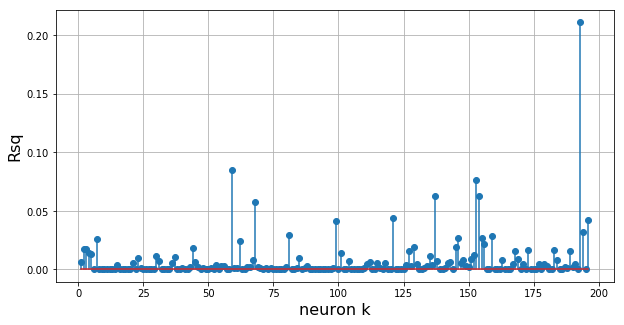

In [12]:
y0_m = np.mean(y0)
syy = np.mean((y0-y0_m)**2)
Rsq = []
for k in range(nneuron):
    xm = np.mean(X0[:,k])
    sxy = np.mean((X0[:,k]-xm)*(y0-y0_m))
    sxx = np.mean((X0[:,k]-xm)**2)
    if sxy != 0:
        Rsq_k = (sxy)**2/sxx/syy
    else:
        Rsq_k = 0
    Rsq.append(Rsq_k)
Rsq = np.array(Rsq)
plt.figure(figsize=(10,5))
plt.figure(1) 
plt.grid()
plt.stem(np.arange(nneuron)+1,Rsq)
plt.xlabel('neuron k', fontsize=16)
plt.ylabel('Rsq', fontsize=16)

In [13]:
d = 100  # Number of neurons to use
Isel_a = np.argsort(Rsq)
Isel = []
for i in range(d):
    Isel.append(Isel_a[Isel_a.shape[0]-1-i])
print("indices of 10 highest correlations:", Isel[0:10])
print("10 highest correlations:",np.round(Rsq[Isel[0:10]],4))

indices of 10 highest correlations: [192, 58, 152, 153, 136, 67, 120, 195, 98, 193]
10 highest correlations: [ 0.2108  0.0847  0.0761  0.0627  0.0623  0.0578  0.0435  0.042   0.0414
  0.0316]


In [14]:
regr = lm.LinearRegression()
regr.fit(Xtr[:,Isel],ytr)
yts_hat = regr.predict(Xts[:,Isel])
RSS_ts1 = np.mean((yts_hat-yts)**2)
RSS_ts2 = RSS_ts1/np.std(yts)**2
print("test RSS per sample  {0:f}".format(RSS_ts1))
print("normalized test RSS {0:f}".format(RSS_ts2))

test RSS per sample  0.001572
normalized test RSS 0.496102


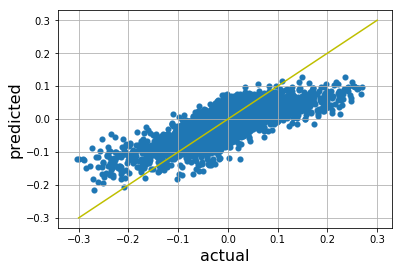

In [15]:
plt.scatter(yts,yts_hat,lw='0.1')
plt.xlabel('actual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.plot([-0.3,0.3],[-0.3,0.3],'y')
plt.grid()

## Using K-fold cross validation for the optimal number of neurons

In [16]:
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
# Model orders to be tested
dtest = np.arange(10,200,10)
# print(dtest.shape)   ----  (19,)
nd = len(dtest)
# Loop over the folds
RSSts = np.zeros((nd,nfold))
for isplit, Ind in enumerate(kf.split(X0)):
    Itr, Its = Ind
    Xtr = X0[Itr]
    ytr = y0[Itr]
    Xts = X0[Its]
    yts = y0[Its]
    for it, d in enumerate(dtest):
        Isel_kf = []
        for i in range(d):
            Isel_kf.append(Isel_a[Isel_a.shape[0]-1-i])
        regr.fit(Xtr[:,Isel_kf],ytr)
        yts_hat = regr.predict(Xts[:,Isel_kf])
        RSSts[it,isplit] = np.mean((yts_hat-yts)**2)

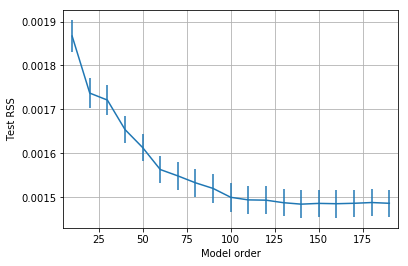

In [17]:
RSS_mean = np.mean(RSSts,axis=1)
RSS_std  = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.xlim([5,195])
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

In [18]:
# Find the minimum RSS target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]
# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
# print(np.where(RSS_mean <= RSS_tgt))
iopt = I[0]
dopt = dtest[iopt]
print(" optimal value of d: %d" % dopt)
print("mean test RSS per sample at the optimal d: %f" % RSS_mean[iopt])

 optimal value of d: 100
mean test RSS per sample at the optimal d: 0.001500


## Using LASSO regression

In [19]:
# (X-mean)/std  
Xs = sklearn.preprocessing.scale(X0)

/Users/Lovely-white/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [20]:
# Create a k-fold cross validation object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
model = lm.Lasso(warm_start=True)
# Regularization values to test
nalpha = 100
alphas = np.logspace(-5,-1,nalpha)
# MSE for each alpha and fold value
RSS = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    # Get the training data in the split
    Itr,Its = ind
    Xs_tr = Xs[Itr,:]
    y_tr = y0[Itr]
    Xs_ts = Xs[Its,:]
    y_ts = y0[Its]   
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        #ia---indexl a----value
        # Fit the model on the training data
        model.alpha = a
        model.fit(Xs_tr,y_tr)        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(Xs_ts)
        RSS[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)  #mean square error
print("done")

done


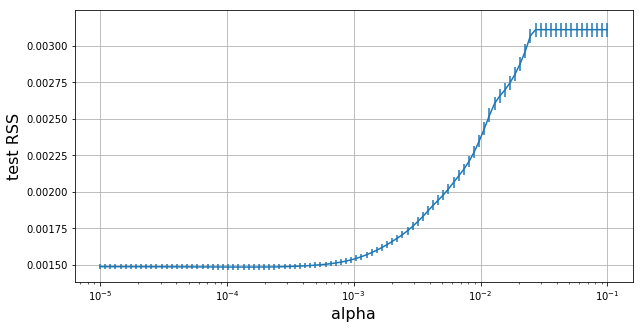

In [21]:
# Compute the mean and standard deviation over the different folds.
RSS_mean = np.mean(RSS,axis=1)
RSS_std = np.std(RSS,axis=1) / np.sqrt(nfold-1)
plt.figure(figsize=(10,5))
plt.figure(1) 
plt.grid()
plt.xlabel('alpha', fontsize=16)
plt.ylabel('test RSS', fontsize=16)
plt.errorbar(alphas, RSS_mean, yerr=RSS_std, fmt='-')
plt.semilogx()
plt.show()

Optimal alpha = 0.000546


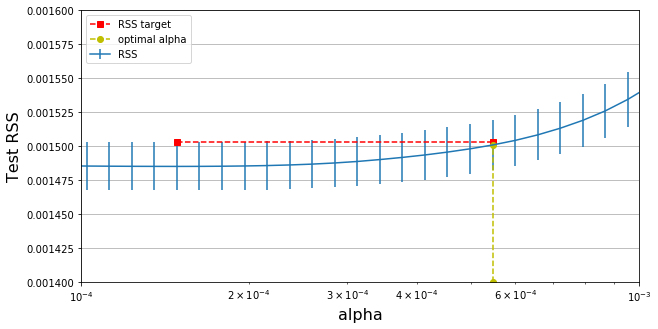

In [22]:
# Find the minimum MSE and MSE target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(RSS_mean < RSS_tgt)[0]  
iopt = I[-1]   
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.figure(figsize=(10,5))
plt.figure(1) 
plt.xlabel('alpha', fontsize=16)
plt.ylabel('test RSS', fontsize=16)
plt.errorbar(alphas, RSS_mean, yerr=RSS_std, fmt='-',label='RSS')
# Plot the MSE target
plt.semilogx([alpha_min,alpha_opt], [RSS_tgt,RSS_tgt], 'rs--',label='RSS target')
# Plot the optimal alpha line
plt.semilogx([alpha_opt,alpha_opt], [0.0014,RSS_mean[iopt]], 'yo--',label='optimal alpha')

plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test RSS')
# plt.ylim([0.35,1.6])
plt.grid()
plt.xlim([1e-4,1e-3])
plt.ylim([0.0014,0.0016])
plt.semilogx()
plt.show()

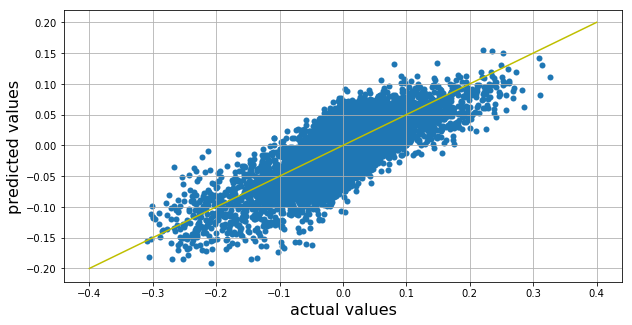

In [23]:
model.alpha = alpha_opt
model.fit(Xs,y0)
y_pred = model.predict(Xs)
plt.figure(figsize=(10,5))
plt.figure(1) 
plt.scatter(y0,y_pred,lw="0.01")
plt.plot([-0.4,0.4],[-0.2,0.2],'y')
plt.grid()
plt.xlabel("actual values", fontsize=16)
plt.ylabel("predicted values", fontsize=16)
